<a href="https://colab.research.google.com/github/arturodeleon19/Data-Science-Projects-NLP-Tensorflow/blob/main/Cyberbullying%20Classification/Cyberbullying_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/cyberbullying-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cyberbullying-classification


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv(path + "/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


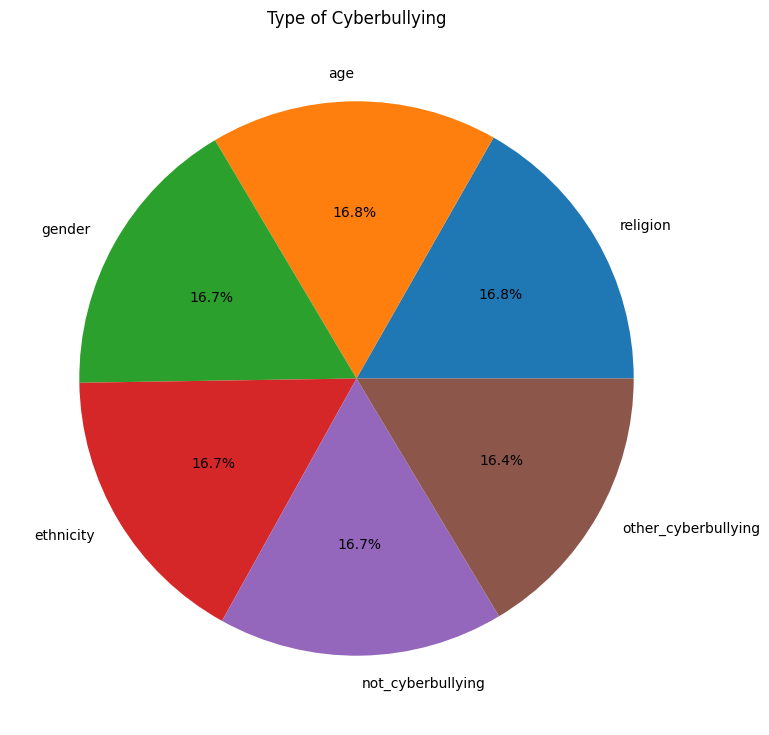

In [ ]:
plt.figure(figsize=(16,9))
Type = df['cyberbullying_type'].value_counts()
plt.pie(Type.values, labels=Type.index, autopct='%1.1f%%')
plt.title('Type of Cyberbullying')
plt.show()

In [ ]:
sample_size = min(10, len(df))
random_sample = df.sample(n=sample_size, random_state=random.randint(1, 1000))

for index, row in random_sample.iterrows():
    print(f"Tweet: {row['tweet_text']}")
    print(f"Cyberbullying Type: {row['cyberbullying_type']}\n")
    print("-" * 50)

Tweet: @MaxBlumenthal Islamophobia - fear of this. http://t.co/Fewr2MFIqn
Cyberbullying Type: religion

--------------------------------------------------
Tweet: It's sum sick dumb ass niggers out here. Fuck up they bed and then mad cuz they gotta lay in it. Better go suck... http://fb.me/8pqN5Soyp
Cyberbullying Type: ethnicity

--------------------------------------------------
Tweet: RT @GradientLair: There is no "friend zone." Please cut the shit. Thanks, management. http://t.co/UmtaqAgbsd
Cyberbullying Type: other_cyberbullying

--------------------------------------------------
Tweet: What I have observed in my own family is akin to all the little kids who follow the bully around the school yard and cheer him on when he picks on the nerd. My family is delighted when Trump slams people verbally. They love the nastiness of his treatment of our
Cyberbullying Type: age

--------------------------------------------------
Tweet: & u r a chutya paistani supporter hence by default pro ter

In [ ]:
X = df['tweet_text']
y = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(),
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train)

(38153, 38153)

In [ ]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)


In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

24

In [ ]:
max_vocab_length = 10000
max_length = 24

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Why is it that all suicide bombers, terrorists, ruthless ISIS killers are typically muslims??? Coz their Quran preaches hatred and genocide. Let muslims go to muslim countries... Haha , even muslims aren't at peace with each other. It's a typical racist religion.      

Vectorized version:


<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[  84,   10,   15,   11,   32,  717, 5149,  220, 5688,  198, 2792,
          12, 4871,   79, 1372,   85,  219, 6248,  672,    5, 1040,  230,
          79,  104]])>

In [ ]:
# Get the unique words vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('to')]
Bottom 5 least common words: [np.str_('reportedly'), np.str_('replacing'), np.str_('repeal'), np.str_('renting'), np.str_('renewed')]


In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             name="embedding_1")

embedding

<Embedding name=embedding_1, built=False>

In [ ]:
time_start = time.time()
model = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

history = model.fit(X_train, y_train)

time_end = time.time()
model_time = time_end - time_start
print(f"Total training time: {model_time:.2f}s")

Total training time: 0.93s


In [ ]:
base_score = model.score(X_test, y_test)
print(f"Our baseline model achieves an accuracy of: {base_score*100:.2f}%")

Our baseline model achieves an accuracy of: 73.42%


In [ ]:
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(6, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_Conv1D")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of model
model_2.summary()

Model: "model_2_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 24)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 24, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,014 (4.97 MB)

 Trainable params: 1,303,014 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

# 1. Convert string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 2. Convert to one-hot
y_train_onehot = to_categorical(y_train_encoded, num_classes=6)
y_test_onehot = to_categorical(y_test_encoded, num_classes=6)

history_2 = model_2.fit(X_train,
                        y_train_onehot,
                        epochs=100,
                        validation_data=(X_test, y_test_onehot),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

end_time = time.time()
model_2_time = end_time - start_time
print(f"Total training time: {model_2_time:.2f}s")

Epoch 1/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6452 - loss: 0.8940 - val_accuracy: 0.7985 - val_loss: 0.5292
Epoch 2/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8350 - loss: 0.4108 - val_accuracy: 0.7927 - val_loss: 0.5550
Epoch 3/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8926 - loss: 0.2726 - val_accuracy: 0.7786 - val_loss: 0.6397
Epoch 4/100
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9247 - loss: 0.1898 - val_accuracy: 0.7703 - val_loss: 0.7324
Total training time: 29.64s


In [ ]:
import tf_keras
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

# Create model using the Sequential API
model_3 = tf_keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(6, activation="softmax")
], name="model_3_USE")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 256831046 (979.73 MB)
Trainable params: 33222 (129.77 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
start_time = time.time()

# Train a classifier on top of pretrained embeddings
history_3 = model_3.fit(X_train,
                        y_train_onehot,
                        epochs=100,
                        validation_data=(X_test, y_test_onehot),
                        callbacks=[tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

end_time = time.time()
model_3_time = end_time - start_time
print(f"Total training time: {model_3_time:.2f}s")

Epoch 1/100
1193/1193 [==============================] - 22s 14ms/step - loss: 0.5807 - accuracy: 0.7912 - val_loss: 0.4812 - val_accuracy: 0.8126
Epoch 2/100
1193/1193 [==============================] - 15s 13ms/step - loss: 0.4439 - accuracy: 0.8212 - val_loss: 0.4677 - val_accuracy: 0.8096
Epoch 3/100
1193/1193 [==============================] - 15s 13ms/step - loss: 0.4252 - accuracy: 0.8272 - val_loss: 0.4562 - val_accuracy: 0.8177
Epoch 4/100
1193/1193 [==============================] - 14s 12ms/step - loss: 0.4104 - accuracy: 0.8332 - val_loss: 0.4545 - val_accuracy: 0.8183
Epoch 5/100
1193/1193 [==============================] - 14s 12ms/step - loss: 0.3976 - accuracy: 0.8377 - val_loss: 0.4488 - val_accuracy: 0.8225
Epoch 6/100
1193/1193 [==============================] - 15s 13ms/step - loss: 0.3858 - accuracy: 0.8425 - val_loss: 0.4450 - val_accuracy: 0.8246
Epoch 7/100
1193/1193 [==============================] - 15s 13ms/step - loss: 0.3743 - accuracy: 0.8476 - val_loss: 0

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
import time

# Ensure X_train/X_test are lists of strings
X_train = X_train.tolist() if hasattr(X_train, 'tolist') else list(X_train)
X_test = X_test.tolist() if hasattr(X_test, 'tolist') else list(X_test)

# Load tokenizer and SBERT model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
sbert_model = TFAutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Tokenize data (returns tf.Tensor)
train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors="tf")
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors="tf")

#
class SBERTLayer(tf.keras.layers.Layer):
    def __init__(self, sbert_model, **kwargs):
        super().__init__(**kwargs)
        self.sbert_model = sbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.sbert_model(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

# Build model
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
sbert_output = SBERTLayer(sbert_model)([input_ids, attention_mask])
outputs = tf.keras.layers.Dense(6, activation="softmax")(sbert_output)
model_4 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
model_4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train
history_4 = model_4.fit(
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y_train_onehot,
    validation_data=(
        {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
        y_test_onehot
    ),
    epochs=100,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

print(f"Total training time: {time.time() - start_time:.2f}s")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - accuracy: 0.7050 - loss: 0.8540 - val_accuracy: 0.7870 - val_loss: 0.5621
Epoch 2/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7922 - loss: 0.5387 - val_accuracy: 0.7952 - val_loss: 0.5342
Epoch 3/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.8020 - loss: 0.5120 - val_accuracy: 0.7990 - val_loss: 0.5234
Epoch 4/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.8064 - loss: 0.4994 - val_accuracy: 0.8012 - val_loss: 0.5176
Epoch 5/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.8093 - loss: 0.4916 - val_accuracy: 0.8032 - val_loss: 0.5139
Epoch 6/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.8108 - loss: 0.4862 - val_accuracy: 0.8046 - val_loss: 0.5112
Epoch 7/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.8117 - loss: 0.4821 - val_accuracy: 0.8061 - val_loss: 0.5093
Epoch 8/100
2385/2385 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 

In [ ]:
model_4_time = 2387.67


=== TRAINING TIME COMPARISON ===


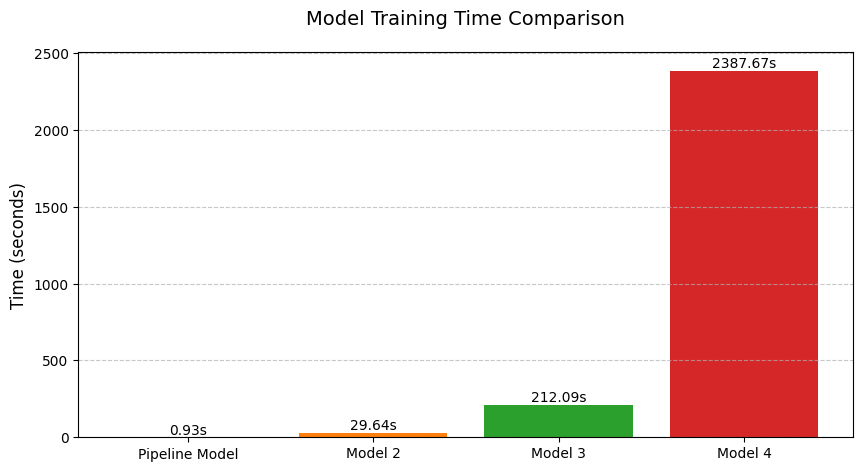


=== TRAINING HISTORY COMPARISON (Models 2-4) ===


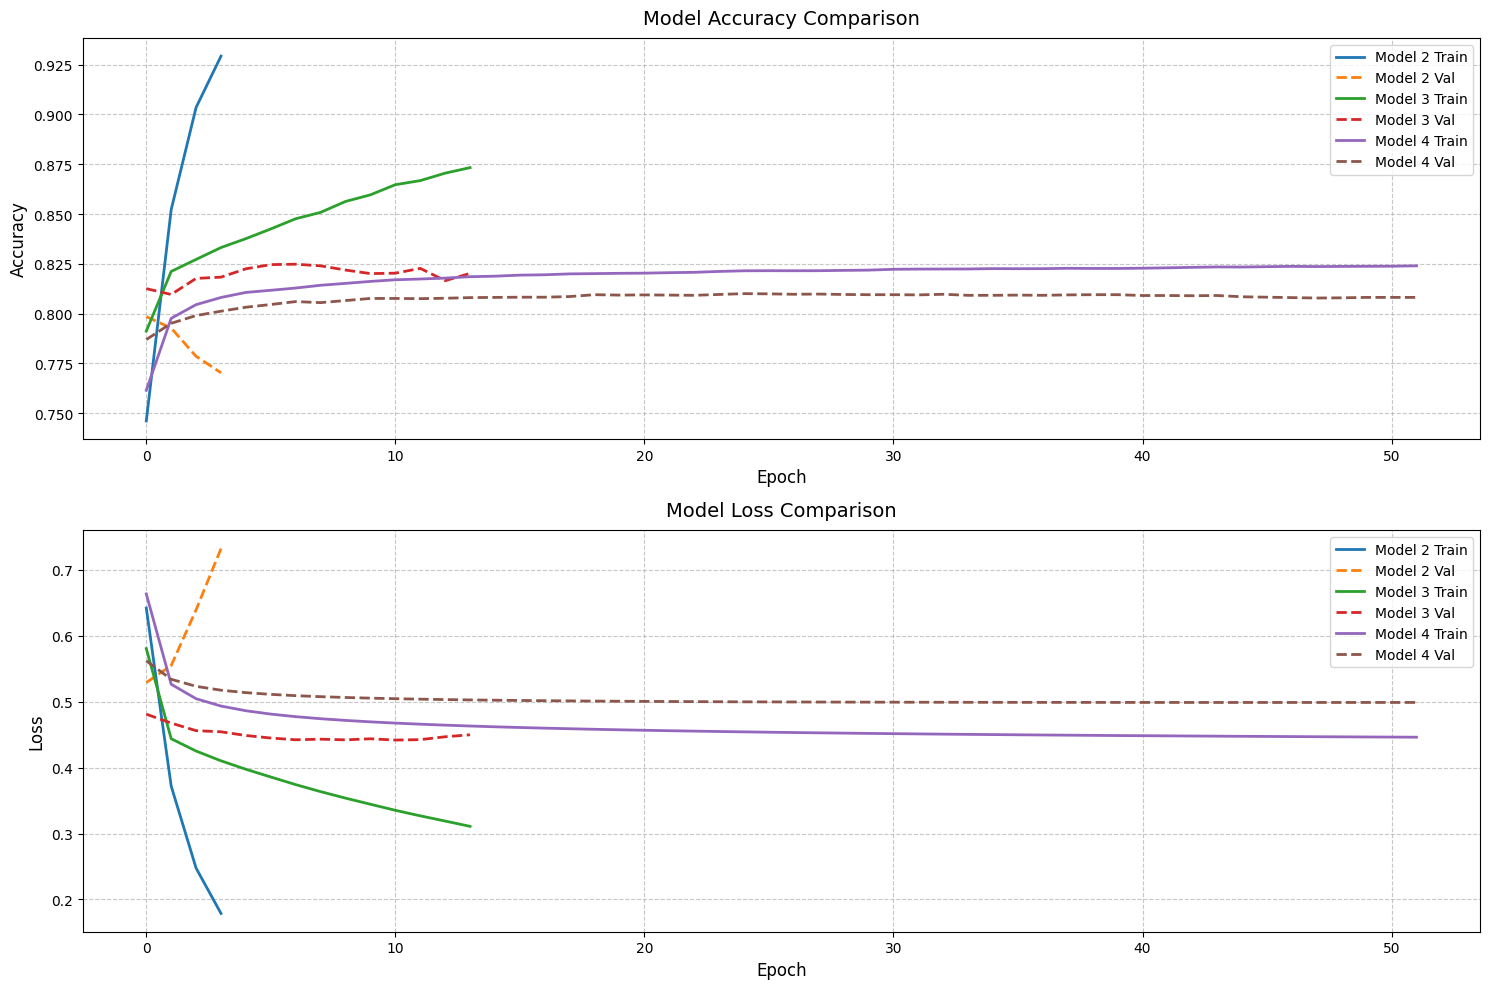


=== CONFUSION MATRICES ===


In [ ]:
def plot_training_times(times, model_names):
    """Plot bar chart comparing training times"""
    plt.figure(figsize=(10, 5))
    bars = plt.bar(model_names, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Model Training Time Comparison', fontsize=14, pad=20)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=10)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_training_histories(histories, model_names):
    """Plot training and validation accuracy/loss for models 2-4"""
    plt.figure(figsize=(15, 10))

    # Accuracy plot
    plt.subplot(2, 1, 1)
    for i, hist in enumerate(histories):
        plt.plot(hist.history['accuracy'], linewidth=2, label=f'{model_names[i+1]} Train')
        plt.plot(hist.history['val_accuracy'], '--', linewidth=2, label=f'{model_names[i+1]} Val')
    plt.title('Model Accuracy Comparison', fontsize=14, pad=10)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Loss plot
    plt.subplot(2, 1, 2)
    for i, hist in enumerate(histories):
        plt.plot(hist.history['loss'], linewidth=2, label=f'{model_names[i+1]} Train')
        plt.plot(hist.history['val_loss'], '--', linewidth=2, label=f'{model_names[i+1]} Val')
    plt.title('Model Loss Comparison', fontsize=14, pad=10)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



# Prepare data
model_names = ['Pipeline Model', 'Model 2', 'Model 3', 'Model 4']
training_times = [model_time, model_2_time, model_3_time, model_4_time]
histories = [history_2, history_3, history_4]
models = [model, model_2, model_3, model_4]

# Generate plots
print("\n=== TRAINING TIME COMPARISON ===")
plot_training_times(training_times, model_names)

print("\n=== TRAINING HISTORY COMPARISON (Models 2-4) ===")
plot_training_histories(histories, model_names)
